In [8]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

In [9]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 16
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)

mean_r = 0.2
scale = 0.02


def f(X):
    r2 = (X[:,0]-0.5)**2 + (X[:,1]-0.4)**2
    r = np.sqrt(r2)
    return -0.5*((r-mean_r)/scale)**2

train_y = f(train_x).reshape(-1,1)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
# ax1.scatter(train_x[:,0],train_x[:,1])
# ax1.set_xlabel(r'$x_1$')
# ax1.set_ylabel(r'$x_2$')
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')

(16, 4) (16, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 1013.57it/s, 7 steps of size 5.72e-01. acc. prob=0.90]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     18.38     24.98     10.75      1.49     38.48     18.33      0.98
_kernel_inv_length_sq[1]      9.59     10.83      6.06      0.96     19.90     25.45      0.97
_kernel_inv_length_sq[2]      0.61      1.64      0.17      0.00      0.96     37.56      0.99
_kernel_inv_length_sq[3]      0.96      0.89      0.64      0.14      2.32     44.06      0.97
        kernel_length[0]      0.59      0.14      0.58      0.37      0.74     32.41      0.97
        kernel_length[1]      0.81      0.29      0.82      0.38      1.08     55.27      0.97
        kernel_length[2]      7.35      8.02      3.99      0.60     15.51     47.58      1.04
        kernel_length[3]      2.65      1.35      2.20      0.95      4.27     77.24      0.98
            kernel_tausq      0.44      0.59      0.29      0.03      0.64     33.55      1.01
              kernel_var     13.63      8.92     

In [10]:
nsteps = 64 # 32
mc_points_size = 16
start = time.time()


ns_skip = 2
fit_skip = 2

for i in range(nsteps):
    if (i%ns_skip==0):
        samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
        print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
        size = len(samples)
        mc_points = samples[::int(size/mc_points_size),:]
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    x0 =  np.random.uniform(0,1,ndim)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)).reshape(-1,1)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    if (i%fit_skip==0):
        gp = saas_fbgp(train_x,train_y,noise=1e-6)
        gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    else:
        gp.quick_update(next_x,next_y)
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

Nested Sampling took 2.89s
jaxns did 46636 likelihood evaluations
LogZ info :logz_mean: = 65.1498, dlogz: = 0.3514, 
Acquisition optimization took 2.49 s
Next point at x = [0.46749553 0.47800522 0.28198337 0.00841649] with acquisition function value = 0.005285943364918697


sample: 100%|██████████| 512/512 [00:00<00:00, 550.97it/s, 15 steps of size 2.87e-01. acc. prob=0.91]



MCMC elapsed time: 1.33s
----------------------Step 1 complete----------------------

Acquisition optimization took 3.82 s
Next point at x = [0.45716571 0.49776419 0.56660772 0.02299454] with acquisition function value = 0.0854663951709638
----------------------Step 2 complete----------------------

Nested Sampling took 2.88s
jaxns did 47064 likelihood evaluations
LogZ info :logz_mean: = 4.6412, dlogz: = 0.3102, 
Acquisition optimization took 3.53 s
Next point at x = [0.42019937 0.45335721 0.21748719 0.64510715] with acquisition function value = 0.08278361766674464


sample: 100%|██████████| 512/512 [00:00<00:00, 571.32it/s, 15 steps of size 3.67e-01. acc. prob=0.89]



MCMC elapsed time: 1.30s
----------------------Step 3 complete----------------------

Acquisition optimization took 3.99 s
Next point at x = [0.38040701 0.40177192 0.43457445 0.56812678] with acquisition function value = 0.0026779693863194006
----------------------Step 4 complete----------------------

Nested Sampling took 2.16s
jaxns did 41217 likelihood evaluations
LogZ info :logz_mean: = -1.1545, dlogz: = 0.3238, 
Acquisition optimization took 2.50 s
Next point at x = [0.45213781 0.61991779 0.95120547 0.96118885] with acquisition function value = 0.010222574216711793


sample: 100%|██████████| 512/512 [00:00<00:00, 558.89it/s, 7 steps of size 3.54e-01. acc. prob=0.96] 



MCMC elapsed time: 1.29s
----------------------Step 5 complete----------------------

Acquisition optimization took 4.48 s
Next point at x = [0.42796592 0.18562846 0.82145628 0.89391314] with acquisition function value = 0.0014056927473601209
----------------------Step 6 complete----------------------

Nested Sampling took 2.40s
jaxns did 33269 likelihood evaluations
LogZ info :logz_mean: = -3.2525, dlogz: = 0.2871, 
Acquisition optimization took 4.44 s
Next point at x = [0.34720721 0.31498486 0.92323722 0.81795816] with acquisition function value = 0.004371947563036164


sample: 100%|██████████| 512/512 [00:00<00:00, 549.36it/s, 7 steps of size 4.71e-01. acc. prob=0.93]



MCMC elapsed time: 1.33s
----------------------Step 7 complete----------------------

Acquisition optimization took 4.72 s
Next point at x = [0.49161323 0.62321391 0.83747612 0.10465364] with acquisition function value = 0.0006685946301252434
----------------------Step 8 complete----------------------

Nested Sampling took 3.00s
jaxns did 37741 likelihood evaluations
LogZ info :logz_mean: = -3.8373, dlogz: = 0.2662, 
Acquisition optimization took 4.93 s
Next point at x = [0.42283147 0.62643117 0.29417326 0.11888768] with acquisition function value = 0.0006936351833653001


sample: 100%|██████████| 512/512 [00:00<00:00, 535.54it/s, 7 steps of size 5.38e-01. acc. prob=0.91] 



MCMC elapsed time: 1.34s
----------------------Step 9 complete----------------------

Acquisition optimization took 3.84 s
Next point at x = [0.35240332 0.21283185 0.13398626 1.        ] with acquisition function value = 0.00029670846915828483
----------------------Step 10 complete----------------------

Nested Sampling took 2.23s
jaxns did 33060 likelihood evaluations
LogZ info :logz_mean: = -4.1445, dlogz: = 0.2661, 
Acquisition optimization took 4.06 s
Next point at x = [0.71089844 0.26912542 0.98710889 0.79575277] with acquisition function value = 0.0010947683810714646


sample: 100%|██████████| 512/512 [00:00<00:00, 531.62it/s, 7 steps of size 5.05e-01. acc. prob=0.93] 



MCMC elapsed time: 1.34s
----------------------Step 11 complete----------------------

Acquisition optimization took 4.83 s
Next point at x = [0.30709227 0.27061951 0.14517426 0.29007709] with acquisition function value = 0.0004512610099702951
----------------------Step 12 complete----------------------

Nested Sampling took 2.26s
jaxns did 29096 likelihood evaluations
LogZ info :logz_mean: = -4.5188, dlogz: = 0.2692, 
Acquisition optimization took 5.27 s
Next point at x = [0.54394499 0.20543841 0.98903668 0.58204168] with acquisition function value = 0.00031401277122669775


sample: 100%|██████████| 512/512 [00:00<00:00, 512.67it/s, 7 steps of size 5.32e-01. acc. prob=0.92]



MCMC elapsed time: 1.44s
----------------------Step 13 complete----------------------

Acquisition optimization took 3.70 s
Next point at x = [0.4048244  0.23540959 0.9193627  0.45191653] with acquisition function value = 9.175498170672057e-05
----------------------Step 14 complete----------------------

Nested Sampling took 2.29s
jaxns did 29726 likelihood evaluations
LogZ info :logz_mean: = -4.6030, dlogz: = 0.2700, 
Acquisition optimization took 2.80 s
Next point at x = [0.55954611 0.61559939 0.76385149 0.54394292] with acquisition function value = 8.919561632893085e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 508.63it/s, 3 steps of size 6.57e-01. acc. prob=0.89] 



MCMC elapsed time: 1.27s
----------------------Step 15 complete----------------------

Acquisition optimization took 0.97 s
Next point at x = [0.30441741 0.44462389 0.63008191 0.45472625] with acquisition function value = 3.940641097730131e-05
----------------------Step 16 complete----------------------

Nested Sampling took 1.95s
jaxns did 34708 likelihood evaluations
LogZ info :logz_mean: = -2.2406, dlogz: = 0.2867, 
Acquisition optimization took 2.51 s
Next point at x = [0.33877961 0.54878019 0.89518416 0.32427246] with acquisition function value = 4.0993518063699164e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 229.47it/s, 3 steps of size 6.82e-01. acc. prob=0.89] 



MCMC elapsed time: 2.59s
----------------------Step 17 complete----------------------

Acquisition optimization took 0.80 s
Next point at x = [0.27893388 0.44215228 0.4323954  0.        ] with acquisition function value = 3.1016332572462654e-05
----------------------Step 18 complete----------------------

Nested Sampling took 1.91s
jaxns did 30240 likelihood evaluations
LogZ info :logz_mean: = -3.3442, dlogz: = 0.2504, 
Acquisition optimization took 0.82 s
Next point at x = [0.30262634 0.43473386 1.         0.4963078 ] with acquisition function value = 3.753608638128354e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 221.19it/s, 7 steps of size 5.93e-01. acc. prob=0.91] 



MCMC elapsed time: 2.63s
----------------------Step 19 complete----------------------

Acquisition optimization took 0.46 s
Next point at x = [0.26083596 0.33523686 0.31988788 0.43760141] with acquisition function value = 2.4976612194303402e-05
----------------------Step 20 complete----------------------

Nested Sampling took 1.88s
jaxns did 29967 likelihood evaluations
LogZ info :logz_mean: = -3.7959, dlogz: = 0.2593, 
Acquisition optimization took 0.86 s
Next point at x = [0.6441116  0.22488359 0.93313853 0.10313826] with acquisition function value = 2.034767747027648e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 224.29it/s, 7 steps of size 7.57e-01. acc. prob=0.84] 



MCMC elapsed time: 2.64s
----------------------Step 21 complete----------------------

Acquisition optimization took 0.46 s
Next point at x = [0.73864257 0.19434171 0.35776962 0.2308841 ] with acquisition function value = 8.889957092934192e-06
----------------------Step 22 complete----------------------

Nested Sampling took 1.83s
jaxns did 28882 likelihood evaluations
LogZ info :logz_mean: = -3.7421, dlogz: = 0.2554, 
Acquisition optimization took 0.30 s
Next point at x = [0.30143861 0.44741268 0.16726651 0.74163581] with acquisition function value = 8.109077994141595e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 204.27it/s, 7 steps of size 6.57e-01. acc. prob=0.88] 



MCMC elapsed time: 2.84s
----------------------Step 23 complete----------------------

Acquisition optimization took 0.44 s
Next point at x = [0.44167879 0.13441002 0.99264851 0.13366704] with acquisition function value = 1.042894178340803e-05
----------------------Step 24 complete----------------------

Nested Sampling took 1.91s
jaxns did 29386 likelihood evaluations
LogZ info :logz_mean: = -3.4809, dlogz: = 0.2519, 
Acquisition optimization took 0.32 s
Next point at x = [0.32916393 0.57168319 0.41810331 0.64497194] with acquisition function value = 1.0087637423040335e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 148.30it/s, 7 steps of size 5.51e-01. acc. prob=0.91] 



MCMC elapsed time: 3.89s
----------------------Step 25 complete----------------------

Acquisition optimization took 0.46 s
Next point at x = [0.40295088 0.20993034 0.         0.59089883] with acquisition function value = 8.551097901510554e-06
----------------------Step 26 complete----------------------

Nested Sampling took 2.13s
jaxns did 30415 likelihood evaluations
LogZ info :logz_mean: = -3.3377, dlogz: = 0.2469, 
Acquisition optimization took 0.72 s
Next point at x = [0.49949696 0.18248075 0.0030533  0.44408363] with acquisition function value = 1.0687249541382893e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 181.20it/s, 7 steps of size 5.22e-01. acc. prob=0.95] 



MCMC elapsed time: 3.14s
----------------------Step 27 complete----------------------

Acquisition optimization took 0.39 s
Next point at x = [0.50805487 0.51596825 0.37920525 0.36487323] with acquisition function value = 6.352372207600945e-06
----------------------Step 28 complete----------------------

Nested Sampling took 3.11s
jaxns did 77169 likelihood evaluations
LogZ info :logz_mean: = 45.3218, dlogz: = 0.3829, 
Acquisition optimization took 4.18 s
Next point at x = [0.99939876 0.91821831 0.36716422 0.40822206] with acquisition function value = 0.0014515026496097726


sample: 100%|██████████| 512/512 [00:03<00:00, 140.58it/s, 7 steps of size 5.94e-01. acc. prob=0.91] 



MCMC elapsed time: 3.96s
----------------------Step 29 complete----------------------

Acquisition optimization took 3.91 s
Next point at x = [0.99906361 0.91079521 0.         0.        ] with acquisition function value = 0.00010840137863499764
----------------------Step 30 complete----------------------

Nested Sampling took 2.12s
jaxns did 35830 likelihood evaluations
LogZ info :logz_mean: = -2.1887, dlogz: = 0.2471, 
Acquisition optimization took 3.12 s
Next point at x = [0.68982703 0.49371713 0.69204346 0.73471316] with acquisition function value = 1.675911576899322e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 171.72it/s, 7 steps of size 6.45e-01. acc. prob=0.92] 



MCMC elapsed time: 3.30s
----------------------Step 31 complete----------------------

Acquisition optimization took 0.44 s
Next point at x = [0.69463685 0.37882614 0.39544257 0.28443625] with acquisition function value = 1.0298539826541706e-05
----------------------Step 32 complete----------------------

Nested Sampling took 1.98s
jaxns did 33057 likelihood evaluations
LogZ info :logz_mean: = -2.5561, dlogz: = 0.2464, 
Acquisition optimization took 1.41 s
Next point at x = [0.68765374 0.4712065  0.99043678 0.95735345] with acquisition function value = 2.8213765652306336e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 167.13it/s, 7 steps of size 6.13e-01. acc. prob=0.92] 



MCMC elapsed time: 3.74s
----------------------Step 33 complete----------------------

Acquisition optimization took 0.88 s
Next point at x = [0.42346489 0.96632847 0.80701421 0.        ] with acquisition function value = 2.5381279410459714e-05
----------------------Step 34 complete----------------------

Nested Sampling took 1.97s
jaxns did 30956 likelihood evaluations
LogZ info :logz_mean: = -2.8341, dlogz: = 0.2477, 
Acquisition optimization took 0.98 s
Next point at x = [0.65856032 0.463304   0.98307786 0.55657115] with acquisition function value = 9.9112619002268e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 164.27it/s, 7 steps of size 7.09e-01. acc. prob=0.88] 



MCMC elapsed time: 3.76s
----------------------Step 35 complete----------------------

Acquisition optimization took 0.89 s
Next point at x = [6.82400572e-01 3.14867137e-01 1.56401270e-01 2.36916989e-06] with acquisition function value = 7.637345065007392e-06
----------------------Step 36 complete----------------------

Nested Sampling took 2.71s
jaxns did 28316 likelihood evaluations
LogZ info :logz_mean: = -2.7318, dlogz: = 0.2427, 
Acquisition optimization took 0.91 s
Next point at x = [0.63848205 0.55477826 0.18849535 0.73645104] with acquisition function value = 1.8711625274468735e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 147.46it/s, 3 steps of size 7.66e-01. acc. prob=0.85] 



MCMC elapsed time: 4.22s
----------------------Step 37 complete----------------------

Acquisition optimization took 0.89 s
Next point at x = [0.3702573  0.71583039 0.32535962 0.48541366] with acquisition function value = 1.5918079657190748e-06
----------------------Step 38 complete----------------------

Nested Sampling took 2.01s
jaxns did 28242 likelihood evaluations
LogZ info :logz_mean: = -2.9641, dlogz: = 0.2451, 
Acquisition optimization took 0.85 s
Next point at x = [0.48979849 0.25413378 0.96049082 0.47866306] with acquisition function value = 3.6212901199893233e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 139.01it/s, 7 steps of size 5.04e-01. acc. prob=0.93] 



MCMC elapsed time: 4.38s
----------------------Step 39 complete----------------------

Acquisition optimization took 0.90 s
Next point at x = [0.70821276 0.50019301 0.         0.45271613] with acquisition function value = 3.25267089296144e-06
----------------------Step 40 complete----------------------

Nested Sampling took 2.30s
jaxns did 32321 likelihood evaluations
LogZ info :logz_mean: = -2.8432, dlogz: = 0.2464, 
Acquisition optimization took 1.69 s
Next point at x = [0.68819284 0.5132765  0.8967433  0.54124807] with acquisition function value = 2.213877322233132e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 131.62it/s, 7 steps of size 5.87e-01. acc. prob=0.92] 



MCMC elapsed time: 4.62s
----------------------Step 41 complete----------------------

Acquisition optimization took 0.86 s
Next point at x = [0.89454853 0.36075982 0.74384168 0.11772059] with acquisition function value = 2.11371772168914e-06
----------------------Step 42 complete----------------------

Nested Sampling took 2.05s
jaxns did 29739 likelihood evaluations
LogZ info :logz_mean: = -2.5499, dlogz: = 0.2392, 
Acquisition optimization took 0.84 s
Next point at x = [0.66412988 0.33119008 0.         0.61814044] with acquisition function value = 2.094325123669534e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 134.07it/s, 7 steps of size 5.95e-01. acc. prob=0.92] 



MCMC elapsed time: 4.50s
----------------------Step 43 complete----------------------

Acquisition optimization took 0.88 s
Next point at x = [0.65175842 0.50695224 0.66673603 0.81653303] with acquisition function value = 1.955641521056428e-06
----------------------Step 44 complete----------------------

Nested Sampling took 2.37s
jaxns did 31031 likelihood evaluations
LogZ info :logz_mean: = -2.5276, dlogz: = 0.2402, 
Acquisition optimization took 0.96 s
Next point at x = [0.30698809 0.83002007 0.07999706 0.10126898] with acquisition function value = 3.0184744029878446e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 142.71it/s, 7 steps of size 6.01e-01. acc. prob=0.91] 



MCMC elapsed time: 4.36s
----------------------Step 45 complete----------------------

Acquisition optimization took 0.89 s
Next point at x = [0.26713053 0.56131393 0.7208882  0.68413669] with acquisition function value = 3.703380867250798e-06
----------------------Step 46 complete----------------------

Nested Sampling took 1.93s
jaxns did 29821 likelihood evaluations
LogZ info :logz_mean: = -2.4490, dlogz: = 0.2445, 
Acquisition optimization took 0.83 s
Next point at x = [0.76796965 0.45203362 0.         0.5039043 ] with acquisition function value = 2.7584343494976155e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 134.34it/s, 7 steps of size 5.70e-01. acc. prob=0.88] 



MCMC elapsed time: 4.44s
----------------------Step 47 complete----------------------

Acquisition optimization took 1.53 s
Next point at x = [0.56433424 0.26502633 0.93951445 0.90937202] with acquisition function value = 2.9739759206202226e-06
----------------------Step 48 complete----------------------

Nested Sampling took 2.07s
jaxns did 31030 likelihood evaluations
LogZ info :logz_mean: = -2.3874, dlogz: = 0.2425, 
Acquisition optimization took 1.48 s
Next point at x = [0.84308544 0.08039196 0.61631448 0.41914555] with acquisition function value = 2.862081275050235e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 111.42it/s, 7 steps of size 7.41e-01. acc. prob=0.89] 



MCMC elapsed time: 5.49s
----------------------Step 49 complete----------------------

Acquisition optimization took 1.65 s
Next point at x = [0.55532373 0.2990136  0.27185142 0.98699973] with acquisition function value = 3.10383753920028e-06
----------------------Step 50 complete----------------------

Nested Sampling took 2.02s
jaxns did 28580 likelihood evaluations
LogZ info :logz_mean: = -2.5133, dlogz: = 0.2467, 
Acquisition optimization took 1.56 s
Next point at x = [0.68062921 0.30719065 0.37992144 0.47842764] with acquisition function value = 2.572996027928702e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 113.93it/s, 3 steps of size 8.46e-01. acc. prob=0.83] 



MCMC elapsed time: 5.40s
----------------------Step 51 complete----------------------

Acquisition optimization took 1.59 s
Next point at x = [0.60449076 0.13066322 0.15145244 0.63888493] with acquisition function value = 2.1835120917051976e-06
----------------------Step 52 complete----------------------

Nested Sampling took 2.05s
jaxns did 30057 likelihood evaluations
LogZ info :logz_mean: = -2.4040, dlogz: = 0.2419, 
Acquisition optimization took 2.54 s
Next point at x = [0.6896168  0.18432056 0.         0.35810151] with acquisition function value = 1.8477658405560357e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 99.91it/s, 7 steps of size 6.14e-01. acc. prob=0.90]  



MCMC elapsed time: 6.01s
----------------------Step 53 complete----------------------

Acquisition optimization took 1.59 s
Next point at x = [0.53860482 0.60629509 0.16716192 0.35877285] with acquisition function value = 1.508838980619244e-06
----------------------Step 54 complete----------------------

Nested Sampling took 2.03s
jaxns did 30236 likelihood evaluations
LogZ info :logz_mean: = -2.5493, dlogz: = 0.2408, 
Acquisition optimization took 1.65 s
Next point at x = [0.31241678 0.60421201 0.92675353 0.90223615] with acquisition function value = 1.9310444932469154e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 103.69it/s, 3 steps of size 6.66e-01. acc. prob=0.90] 



MCMC elapsed time: 5.94s
----------------------Step 55 complete----------------------

Acquisition optimization took 1.67 s
Next point at x = [0.         0.84852588 0.99884527 0.87830438] with acquisition function value = 2.5017588717061653e-06
----------------------Step 56 complete----------------------

Nested Sampling took 2.00s
jaxns did 28887 likelihood evaluations
LogZ info :logz_mean: = -2.6196, dlogz: = 0.2424, 
Acquisition optimization took 1.60 s
Next point at x = [0.72104044 0.31771737 0.09406356 0.72028467] with acquisition function value = 1.7432029166576657e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 96.81it/s, 7 steps of size 5.63e-01. acc. prob=0.94]  



MCMC elapsed time: 6.17s
----------------------Step 57 complete----------------------

Acquisition optimization took 1.70 s
Next point at x = [0.68179462 0.09574469 0.58324053 0.62922709] with acquisition function value = 1.3168867042702426e-06
----------------------Step 58 complete----------------------

Nested Sampling took 2.11s
jaxns did 31004 likelihood evaluations
LogZ info :logz_mean: = -2.7224, dlogz: = 0.2429, 
Acquisition optimization took 1.74 s
Next point at x = [0.17119986 0.2726301  0.51148795 0.33241887] with acquisition function value = 1.2205498166519696e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 98.94it/s, 7 steps of size 5.96e-01. acc. prob=0.90]  



MCMC elapsed time: 6.18s
----------------------Step 59 complete----------------------

Acquisition optimization took 1.73 s
Next point at x = [0.78900217 0.70448642 0.74053271 0.27034084] with acquisition function value = 1.259888725417893e-06
----------------------Step 60 complete----------------------

Nested Sampling took 1.98s
jaxns did 28789 likelihood evaluations
LogZ info :logz_mean: = -2.7210, dlogz: = 0.2382, 
Acquisition optimization took 1.73 s
Next point at x = [0.37485511 0.53402906 0.65665635 0.54297758] with acquisition function value = 1.3052804357562703e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 75.96it/s, 7 steps of size 5.66e-01. acc. prob=0.91]  



MCMC elapsed time: 7.69s
----------------------Step 61 complete----------------------

Acquisition optimization took 1.92 s
Next point at x = [0.33298379 0.29891809 0.22157035 0.81341315] with acquisition function value = 1.4549205650726468e-06
----------------------Step 62 complete----------------------

Nested Sampling took 2.14s
jaxns did 30922 likelihood evaluations
LogZ info :logz_mean: = -2.6992, dlogz: = 0.2418, 
Acquisition optimization took 1.93 s
Next point at x = [0.49007704 0.8373182  0.31378915 0.83630353] with acquisition function value = 1.652312934514663e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 78.52it/s, 7 steps of size 6.06e-01. acc. prob=0.94]  



MCMC elapsed time: 7.54s
----------------------Step 63 complete----------------------

Acquisition optimization took 1.96 s
Next point at x = [0.25566991 0.5051298  1.         0.66219353] with acquisition function value = 1.5807322850790867e-06
----------------------Step 64 complete----------------------

BO took 332.13 s 


In [11]:
print(gp.train_x.shape,gp.train_y.shape)

(80, 4) (80, 1)


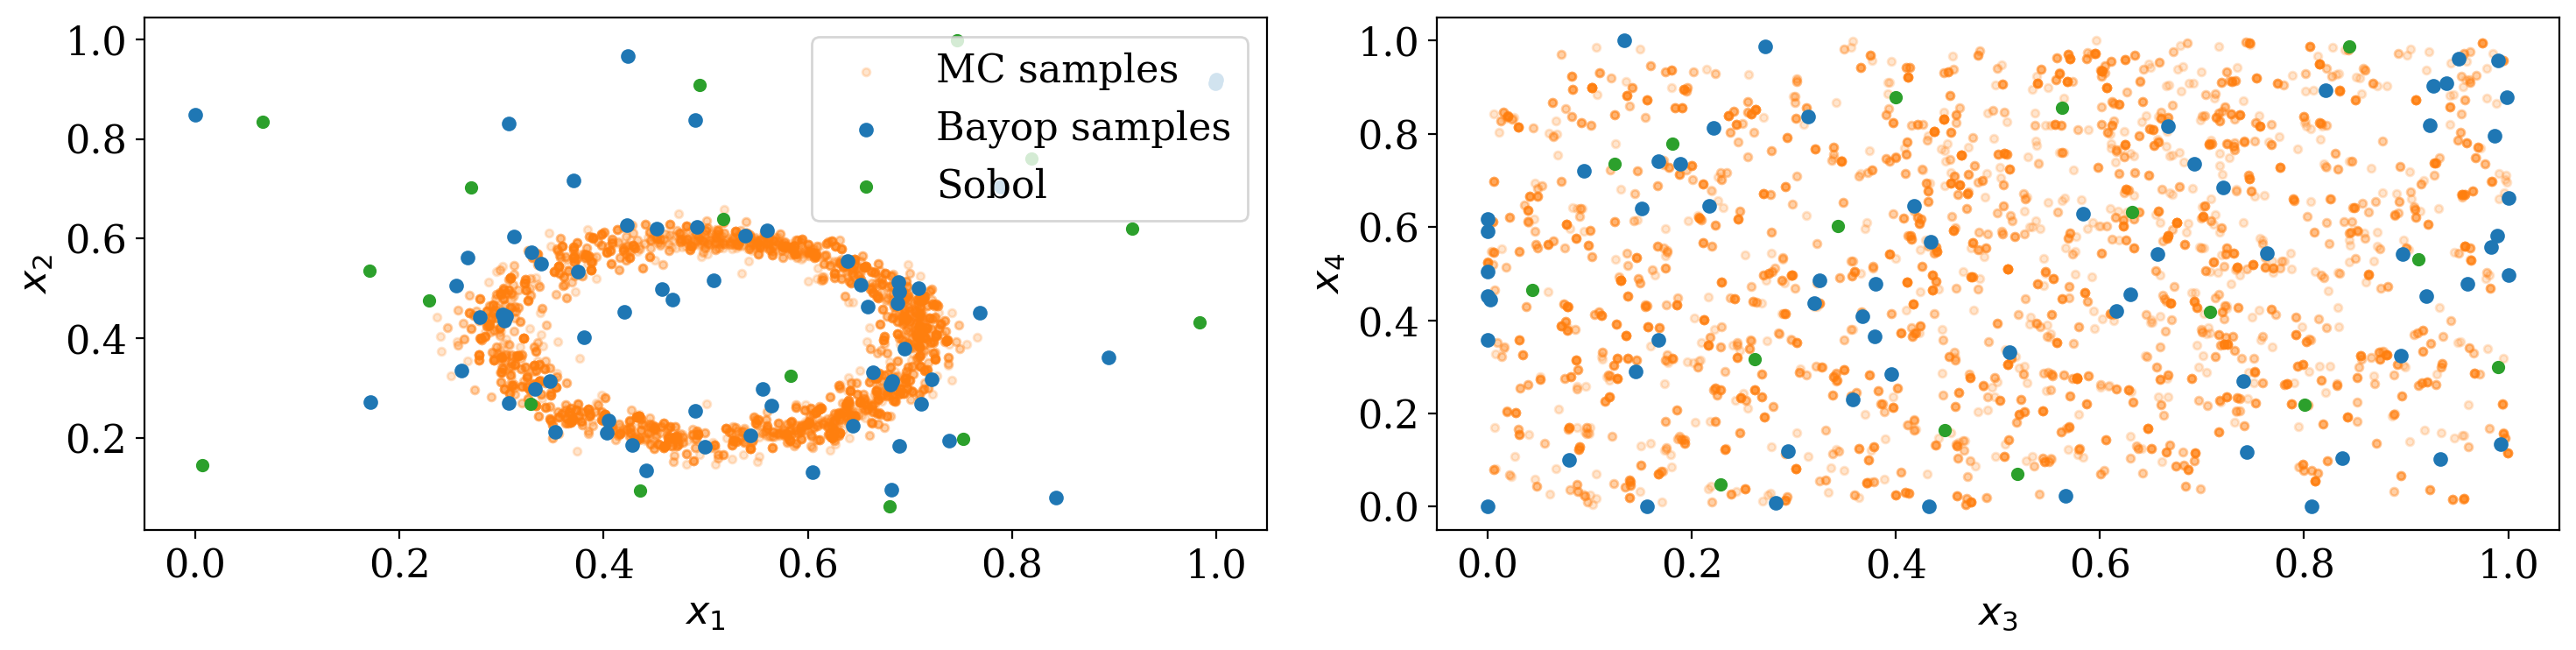

In [12]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(15,4))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    # x.axvline(f_mean[2*i],ls='-.',color='k')
    # x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()
fig.tight_layout()

In [13]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

Nested Sampling took 8.77s
jaxns did 390726 likelihood evaluations
LogZ logz_mean: -2.6597, dlogz: 0.1356, 


Removed no burn in
Removed no burn in


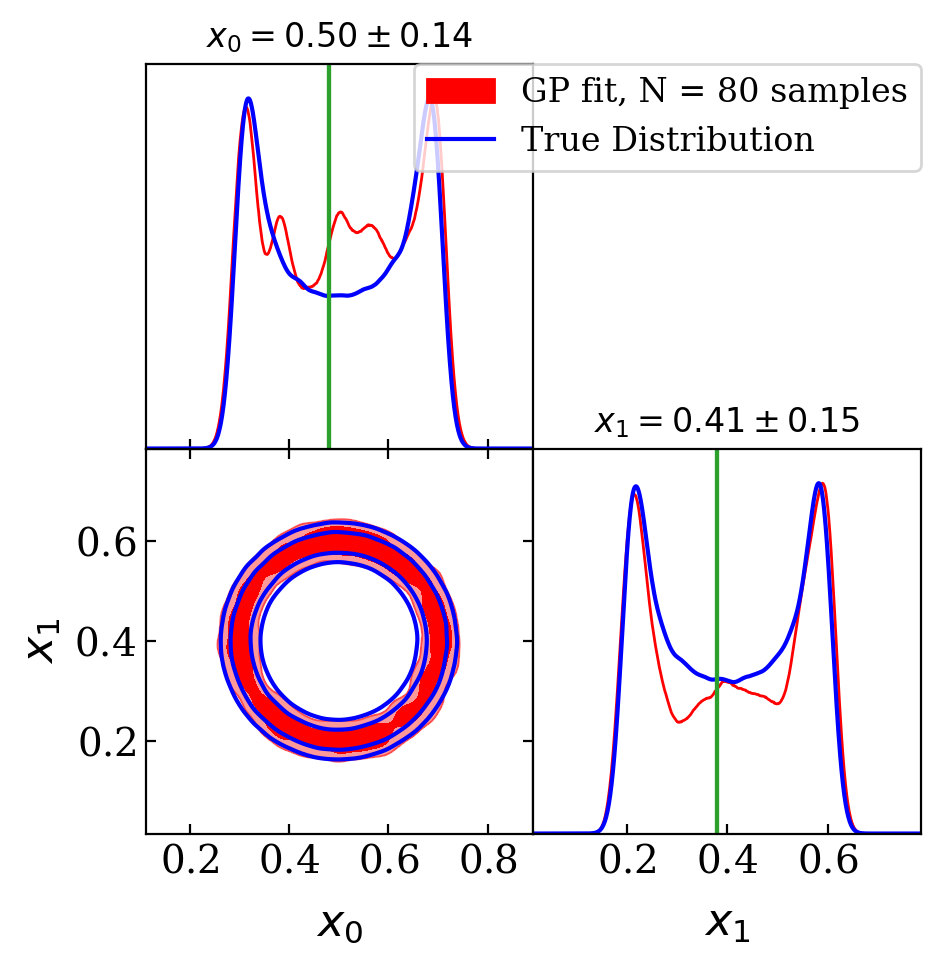

In [15]:
size = int(5e5)
rs = np.random.normal(loc=mean_r,scale=scale,size=size)
thetas = 2*np.pi*np.random.rand(size)
xs = abs(rs)*np.cos(thetas)+0.5
ys = abs(rs)*np.sin(thetas)+0.4
xys = np.array([xs,ys]).T

labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=xys,names=names[:2], labels = labels[:2],ranges=ranges[:2]) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names[:2],filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],title_limit=1,)
                                # markers = dict(zip(names[:2],[0.])),
                                # marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'}) # type: ignore

locs = np.array([0.5,0.4])
for i in range(2):
    ax = g.subplots[i,i]
    ax.axvline(locs[i]-scale, color='C2', ls='-')
    ax.axvline(locs[i]-scale, color='C2', ls='-')


